# Using DineSafe Data to Visualize Business Turnover
#### Fabienne Chan - January 2019 


---

# Index
### [Introduction](#intro)
### [Part I. Methodology](#methodology)
- [1.1 Data Origin](#data_origin)
- [1.2 Cleaning](#cleaning)
- [1.3 Feature Engineering](#feature_engineering)


### [Part II. Analysis](#analysis)
- [2.1 Closures](#closures)
- [2.2 Turnover](#turnover)
- [2.2.1 Turnover by Former Municipality](#turnover_by_fm)
- [2.2.2 Turnover by Neighbourhood](#turnover_by_n)
- [2.2.3 Turnover by Address](#turnover_by_a)

### [Conclusion](#conclusion)
### [Footnotes](#footnote)

---

---
## Introduction 
<a id="intro"></a>

The purpose of this study is to visualize food-establishment turnover in the City of Toronto using DineSafe inspection data. Establishments that handle food are required to undergo **at least one inspection per year**. As such, it's fair to assume that the DineSafe data provides annual snapshots of all food-establishments in Toronto. Premised upon this, this analysis aims to visualize establishment turnover, which may act as a means to indicate the economic health of an area, particularly areas downtown. 

During the analysis, it was found through conversations with a DineSafe Quality Assurance staff that understaffing issues have resulted in certain low-risk food-establishments (e.g. convenience stores) skipping up to two years of inspections. Acknowledging this and other shortcomings in data methodology, this analysis will focus on surface-level findings.

#### This notebook will be split in two key parts: (1) [Methodology](#methodology) and (2) [Analysis](#analysis).


--- 



# Part I. Methodology 
<a id="methodology"></a>

## 1.1 Data Origin 
<a id="data_origin"></a>

Data was downloaded from the City of Toronto's [Open Data portal](https://www.toronto.ca/city-government/data-research-maps/open-data/) as of December 12th, 2018. However, this data only dates back two years. To extend our horizon, we accessed  the Web Archive (thanks [Twitter!](https://twitter.com/SherylsCrush/status/1068618721650982914)) and obtained DineSafe data since July 2011<sup>1</sup>. Since half of 2011 was missing, we decided to remove this year and start with a complete set of 2012 data. We acknowledge that the last two weeks or so of 2018 data are missing from our study, but we can also anticipate this will have minimal impact on our exploratory analysis.

#### Preliminary Cleaning
Because XML is gross, we formatted the raw data into a readable DataFrame. 

Original data showed the exact inspection date. As we only care about year, we converted that column to show only year.

Depending on their 'safety hazard' classification, establishments are inspected between one and three times a year. This would result in duplicates, whereas we only want establishments to appear maximum of once per year (to indicate existence). So as part of the preliminary cleaning process, we removed duplicated instances of **Establishment_IDs** per year.

#### Geocoding
Interestingly, only the December 2018 dataset had Latitude and Longitude attributes. We geocoded the remaining address using a combination of matching with available addresses, matching with [One Address Repository](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#f71a13c4-fb51-6116-57b7-1f51a8190585) addresses, and using Google's Geocoding API.

More cleaning/processing needs to be done but below is the initial dataset we have to work with:

In [1]:
# Import libraries
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mapboxgl.utils import *
from mapboxgl.viz import *

# Set display options
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_colwidth", 200)

# Load pre-processed Dinesafe Dataframe:
with open('Data/preprocessed_ds.csv','r') as f:
    ds = pd.read_csv(f, index_col = None)

print("We have {:,} rows of data and {:,} unique Establishment_IDs.".format(len(ds), len(ds['ESTABLISHMENT_ID'].unique())))
ds[:20]

We have 99,587 rows of data and 27,400 unique Establishment_IDs.


,Year,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,ESTABLISHMENT_ID,ESTABLISHMENT_NAME,INSPECTION_ID,LATITUDE,LONGITUDE,risk_level
0,2012,Restaurant,5641 STEELES AVE E,10185207,TIM HORTONS,102778249,43.832617,-79.266886,2
1,2013,Restaurant,5641 STEELES AVE E,10185207,TIM HORTONS,103071804,43.832617,-79.266886,2
2,2014,Restaurant,5641 STEELES AVE E,10185207,TIM HORTONS,103385541,43.832617,-79.266886,2
3,2015,Restaurant,5641 STEELES AVE E,10185207,TIM HORTONS,103460005,43.832617,-79.266886,2
4,2016,Restaurant,5641 STEELES AVE E,10185207,TIM HORTONS,103873791,43.832617,-79.266886,2
5,2017,Restaurant,5641 STEELES AVE E,10185207,TIM HORTONS,103985362,43.832617,-79.266886,2
6,2018,Restaurant,5641 STEELES AVE E,10185207,TIM HORTONS,104152523,43.832617,-79.266886,2
7,2012,Institutional Food Service,15 BARBERRY PL,10185216,AMICA AT BAYVIEW,102877974,43.766412,-79.384040,3
8,2013,Retirement Homes(Licensed),15 BARBERRY PL,10185216,AMICA AT BAYVIEW,102975081,43.766412,-79.384040,3
9,2014,Retirement Homes(Licensed),15 BARBERRY PL,10185216,AMICA AT BAYVIEW,103214685,43.766412,-79.384040,3


In [2]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99587 entries, 0 to 99586
Data columns (total 9 columns):
Year                     99587 non-null int64
ESTABLISHMENTTYPE        99587 non-null object
ESTABLISHMENT_ADDRESS    99587 non-null object
ESTABLISHMENT_ID         99587 non-null int64
ESTABLISHMENT_NAME       99587 non-null object
INSPECTION_ID            99587 non-null int64
LATITUDE                 99587 non-null float64
LONGITUDE                99587 non-null float64
risk_level               99587 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 6.8+ MB


We have 99,587 rows of data. Ultimately, we want to transform this data into a DataFrame that shows when establishments existed each year, from which we can visualize 'change' year over year. But first we need to clean out certain datapoints which may add noise from our study. As we can see from the graph below, the majority of food establishments are restaurants and take-out spots.

#### Caveats
- While most addresses are for standalone establishments, it's important to highlight that several are retail plazas. As such, several establishments could exist simultaneously, disallowing us from pursuing the easy route of simply grouping our data by address to show turnover. Doing so would cause one establishment to incorrectly represent a plaza that may actually have 10 establishments. To account for this, we first group by **Establishment_ID** in a dataframe then, from that dataframe, group by address (explained in the following 'Cleaning' section).


- We noticed that some establishments would skip a year of inspection - despite the requirement for having a minimum of one inspection per year. Per conversations with DineSafe staff, this was due to staffing issues and a backlog in inspections. This was more likely for low risk establishments like Gateway Newsstands. Standards were higher for high risk level establishments (e.g. those that handled raw meats). 

 To address this, we built a function that would selectively fill in gaps in years (in separate notebook on [GitHub](https://github.com/fabhlc/DineSafe_Gentrification)).


- Although an address may have the same name through the years, we also notice sometimes the **Establishment_ID** would change. DineSafe staff noted that any change in establishment ID is a result of change in ownership. In certain cases, this could mean the establishment continued operations under new management (owner). We count this as a 'change'. Notably, renovations do not result in a change in **Establishment_ID**. 

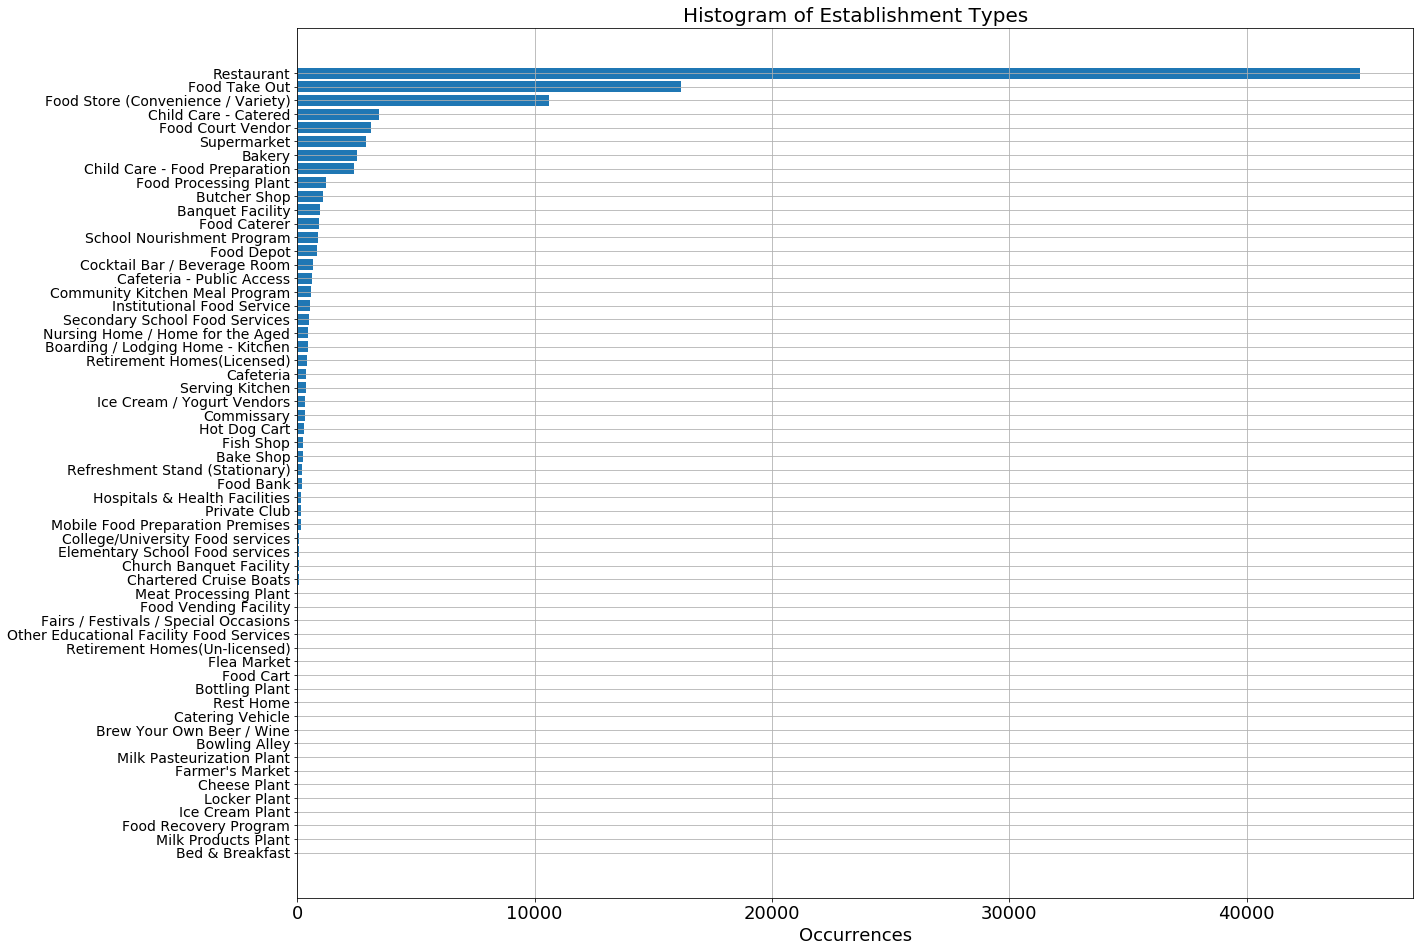

In [3]:
type_labels = ds['ESTABLISHMENTTYPE'].value_counts().keys()
fig, ax = plt.subplots(figsize = (20, 16))
ax.barh(width = ds['ESTABLISHMENTTYPE'].value_counts(), y = range(len(type_labels)))
plt.yticks(range(len(type_labels)), type_labels, fontsize = 14)
plt.xlabel("Occurrences", size = 18)
plt.xticks(size = 18)
plt.title('Histogram of Establishment Types', fontsize = 20)
ax.invert_yaxis()
plt.grid()
plt.show()

To keep this notebook concise, you can find detailed steps for data cleaning and transformation (including criteria for keeping certain establishment types) in a separate notebook in my [GitHub](https://github.com/fabhlc/DineSafe).

## 1.2 Cleaning 
<a id="cleaning"></a>

Firstly, we rid the data of establishment types that may not necessarily aid our analysis. This includes things like Retirement Homes wth catering services, mobile hot dog carts, hospitals, and cruise boats. Food court vendors were also removed from our data as we wanted to concentrate the focus on standalone restaurants. This leaves us at 86,079 rows.

Next we remove data from large venues and stadiums like *Exhibition Place, Rogers Centre*, and *Downsview Flea Market*. Similarly, these often have different characteristics that impact turnover rates differently compared to 'stand-alone' addresses we're looking at. We are now at 83,520 rows.

Minor cleanups were needed along the way, such as correcting "5078 DUNDAS ST E" to "5078 DUNDAS ST W", replacing "&" with "AND" for consistency, and replacing apostrophes.

#### Key DataFrames
From our original data, we derive two key dataframes:
1. **turnover**: Turnover by Establishment ID
2. **turnover_address**: Turnover by address and their associated neighbourhoods. (Neighbourhood association executed by QGIS)

## 1.3 Feature Engineering 
<a id="feature_engineering"></a>
#### Dataframe 1: turnover 
This first dataframe was built to show in which years establishments existed. A key feature engineered out of the data and shown as columns in this dataframe is **yearly change**. This binary data indicates whether an establishment continued its existence or non-existence from year to year. For example, if an establishment existed in 2012 but ceased in 2013, this would be indicated by a "1" in change_2013. 

As previously mentioned, certain establishments show gaps in existence (as a very real consequence of staffing issues). We built a function to fill in these gaps. Essentially, where there were more than two 'changes' in the six 'change' columns, the function would convert these existence gaps from 0 to 1. 


#### Dataframe 2: turnover_address
From the first dataframe, we grouped the data by address to shift the focus on addresses, creating the second dataframe, **'turnover_address'**. Additional features were engineered out of this to measure change:
- ** Total Turnover**: This is the total number of changes at this address (e.g. sum of all closures and openings).
- ** Annual Turnover** : Total turnover divided by the number of years (six).
- ** Max Units **: Maximum number of units existing at a single address in any given year between 2012 and 2018. (Ideally we would have data on the number of retail units at an address. This assumption would be the next best thing).
- ** Change Index **: annual turnover divided by max units (to account for different weights of addresses with multiple establishment units). 
- ** Multi Units **: Binary for if there is more than one establishment at this address.

#### Change Index
Change Index values typically span from 0 to 1, with zero indicating no change throughout the six year period. For example, a Change Index of 0.5 would mean an address has a 50% chance of 'changing' each year, whether by closure or new opening. The city-wide average change index of 0.2114 indicates food-establishment addresses have a 21% chance of turning over each year.

Only 11 addresses (0.09% of addresses) exceed 1.0 and range from 1.33 to 1.67. This is because openings and closings in establishments account for 'one' change each, so if an establishment closes by the end of 2014 and another opens in its place in 2015, **change_2015** would have a value of 2.


Let's load these three dataframes into this notebook.

In [4]:
with open('Data/turnover_id.csv', 'r') as f:
    turnover = pd.read_csv(f, index_col = None)
turnover[:15]

,name,address,exist_2012,exist_2013,exist_2014,exist_2015,exist_2016,exist_2017,exist_2018,change_2013,change_2014,change_2015,change_2016,change_2017,change_2018
0,"""FOOD APPEAL.CA INC.""",222 ISLINGTON AVE,0,0,0,0,1,0,0,0,0,0,1,1,0
1,(FAMOUS PLAYERS )CINEPLEX ENTERTAINMENT,2190 YONGE ST,0,0,1,0,0,0,0,0,1,1,0,0,0
2,0109 DESSERT + CHOCOLATE,2190 MCNICOLL AVE,0,0,1,1,0,0,0,0,1,0,1,0,0
3,1 PLUS 1 PIZZA,361 OAKWOOD AVE,0,0,1,1,1,1,1,0,1,0,0,0,0
4,1 PLUS 2 PIZZA AND WING,3260 DUNDAS ST W,1,1,1,1,1,0,0,0,0,0,0,1,0
5,1 PLUS 2 PIZZA AND WINGS,1540 DANFORTH AVE,1,1,1,1,0,0,0,0,0,0,1,0,0
6,1 PLUS 3 PIZZA AND WINGS,1798 JANE ST,1,1,1,1,1,0,0,0,0,0,0,1,0
7,100 HUMBER COLLEGE CAFE,100 HUMBER COLLEGE BLVD,1,1,1,1,0,0,0,0,0,0,1,0,0
8,100 KM FOODS INC.,4478 CHESSWOOD DR,1,0,0,0,0,0,0,1,0,0,0,0,0
9,100 POR SIENTO SALVADORENO,404 OLD WESTON RD,0,0,0,0,1,0,0,0,0,0,1,1,0


In [5]:
with open('Data/turnover_address (QGIS_withneighbourhoods).csv', 'r') as f:
    turnover_address = pd.read_csv(f, index_col = None)
    
# Create a more compact dataframe without the change/exist columns
turnover_address_1 = pd.concat((turnover_address.sort_values('change_index', ascending = False).iloc[:,:1],
                                turnover_address.sort_values('change_index', ascending = False).iloc[:,14:]), axis = 1)

turnover_address[:15]

,address,exist_2012,exist_2013,exist_2014,exist_2015,exist_2016,exist_2017,exist_2018,change_2013,change_2014,change_2015,change_2016,change_2017,change_2018,total_turnover,annual_turnover,max_units,change_index,multi_units,LATITUDE,LONGITUDE,AREA_NAME
0,1 BALMORAL AVE,1,1,1,1,1,1,1,0,0,2,0,0,0,2,0.33333,1,0.33333,0,43.68554,-79.39342,Yonge-St.Clair (97)
1,11 ST CLAIR AVE W,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0.00000,1,0.00000,0,43.68777,-79.39457,Yonge-St.Clair (97)
2,111 ST CLAIR AVE W,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0.16667,1,0.16667,0,43.68665,-79.39951,Yonge-St.Clair (97)
3,1208 YONGE ST,0,0,1,1,1,1,1,0,1,0,0,0,0,1,0.16667,1,0.16667,0,43.68172,-79.39171,Yonge-St.Clair (97)
4,1210 YONGE ST,0,0,0,0,1,1,0,0,0,0,1,0,1,2,0.33333,1,0.33333,0,43.68175,-79.39174,Yonge-St.Clair (97)
5,1234 YONGE ST,1,1,1,1,1,1,1,0,0,0,2,0,0,2,0.33333,1,0.33333,0,43.68258,-79.39211,Yonge-St.Clair (97)
6,1240 YONGE ST,1,1,0,0,0,1,1,0,1,0,0,1,0,2,0.33333,1,0.33333,0,43.68292,-79.39220,Yonge-St.Clair (97)
7,1246 YONGE ST,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0.16667,1,0.16667,0,43.68304,-79.39234,Yonge-St.Clair (97)
8,1250 YONGE ST,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0.16667,1,0.16667,0,43.68312,-79.39246,Yonge-St.Clair (97)
9,1272 YONGE ST,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0.16667,1,0.16667,0,43.68357,-79.39248,Yonge-St.Clair (97)


Out of these dataframes, we'll create a reference dataframe that will quickly show us the establishments associated with each address. This will come in handy for mapping later.

In [6]:
# Create a reference table for establishments and addresses.

turnover['first_exist'] = ['201'+str(list(i).index(1)) for i in turnover.values]
ests = turnover.groupby('address')['name'].apply(list)
yrs = turnover.groupby('address')['first_exist'].apply(list)
zipped = list(zip(ests, yrs))

est_by_add = pd.DataFrame(ests).join(pd.DataFrame(yrs))
est_by_add.reset_index(inplace=True)

# Clean fields to make it more readable. "Esta." must be clean as it will feed into the map labels later.
est_by_add['Esta.'] = [list(zip(i,j)) for (i,j) in zipped] 
est_by_add['name'] = [", ".join(i) for i in est_by_add['name']]
est_by_add['first_exist'] = [", ".join(i) for i in est_by_add['first_exist']]
est_by_add['Esta.'] = [", ".join(["{} ({})".format(j[0].title(), j[1]) for j in i]) for i in est_by_add['Esta.']]

est_by_add[:15]

,address,name,first_exist,Esta.
0,1 ADELAIDE ST E,"CRAFT BEER MARKET RESTAURANT AND BAR, INTERNATIONAL NEWS, STARBUCKS","2017, 2012, 2012","Craft Beer Market Restaurant And Bar (2017), International News (2012), Starbucks (2012)"
1,1 AUSTIN TER,"BLUE BLOOD STEAKHOUSE, CASA LOMA, SIR HENRYS CAFE","2017, 2012, 2012","Blue Blood Steakhouse (2017), Casa Loma (2012), Sir Henrys Cafe (2012)"
2,1 AVONDALE AVE,"PIZZA NOVA, STARBUCKS COFFEE CO","2012, 2012","Pizza Nova (2012), Starbucks Coffee Co (2012)"
3,1 BALDWIN ST,"MO RAMYUN, YAKITORI BAR AND SEOUL FOOD COMPANY","2015, 2013","Mo Ramyun (2015), Yakitori Bar And Seoul Food Company (2013)"
4,1 BALMORAL AVE,"BARNSTEINERS, JOHN AND SONS OYSTER HOUSE","2015, 2012","Barnsteiners (2015), John And Sons Oyster House (2012)"
5,1 BAXTER ST,"EL TENEDOR, GOLDEN MINT, THE MINT COFFEE AND TEA CO.","2016, 2013, 2015","El Tenedor (2016), Golden Mint (2013), The Mint Coffee And Tea Co. (2015)"
6,1 BEDFORD RD,STARBUCKS COFFEE,2012,Starbucks Coffee (2012)
7,1 BENVENUTO PL,SCARAMOUCHE,2012,Scaramouche (2012)
8,1 BESTOBELL RD,FANTIS FOODS OF CANADA LTD.,2012,Fantis Foods Of Canada Ltd. (2012)
9,1 BLOOR ST E,STARBUCKS,2018,Starbucks (2018)


---


# Part II. Analysis 
<a id="analysis"></a>

Let's take a look at the geographical distribution of food-establishments. Below is a heatmap showing where food establishment addresses are concentrated (weighted by **max_units**) over a basemap comprising boundaries for the City of Toronto's official 140 neighbourhoods (numbered).

<img src="https://raw.githubusercontent.com/fabhlc/DineSafe/master/Images%20and%20Maps/geospatial.png">

A closer look at the concentration downtown unsurprisingly shows concentrations along main arterials, particularly those with subway lines. Kensington Market appears to have one of the densest clusters of food establishments, followed by food courts at 10 Dundas across from Dundas Square, and the food courts along the PATH.

<img src="https://raw.githubusercontent.com/fabhlc/DineSafe/master/Images%20and%20Maps/geospatialzoom.png">

## 2.1 Closures 
<a id="closures"></a>
While heatmaps are great for showing geospatial concentrations, they are less suited in helping us visualize the magnitude of turnovers and closures as they will get conflated with geospatially-concentrated retail areas. Looking at closures may provide us with a better sense of where businesses are being pushed out. Let's look at establishments that existed in 2012 but ceased to exist 2018 onwards (i.e. closed anytime between 2013 and 2017).

In [7]:
closures = turnover[(turnover['exist_2012'] == 1) & (turnover['exist_2018'] == 0)]
closures = closures.join(turnover_address[['address', 'LATITUDE','LONGITUDE', 'AREA_NAME']].set_index('address'), 
                         on = 'address', how = 'left')

# How many closed in 2014? In 2015? 2016?
print("{:,} food-establishments closed in 2013.\n{:,} closed in 2014.\n{:,} closed in 2015.\n{:,} closed in 2016.".format(sum(closures['change_2013']),
                                                                              sum(closures['change_2014']),
                                                                             sum(closures['change_2015']),
                                                                             sum(closures['change_2016'])))

557 food-establishments closed in 2013.
1,481 closed in 2014.
717 closed in 2015.
728 closed in 2016.


There was a shockingly high number of restaurant closures in 2014 - more than double that of adjacent years. A quick Google dive shows us the prolific Mr Greenjeans was among the list of casualties, after a long 34-year run in the Eaton Centre.

<img src="https://raw.githubusercontent.com/fabhlc/DineSafe/master/Images%20and%20Maps/greenjeans.jpg">
<div style="text-align: center"><i> Mr. Greenjeans Restaurant. (RIP. 1980 to 2014) Source: TripAdvisor </i> </div>

The bulk of 2014's closures were downtown in the Bay Street Corridor neighbourhood (see table below). Most of these closures were fast-food type of businesses, like Tim Hortons, grab-n-go sushi shops, and Gateway Newsstands. Keeping in mind this area has a dense clustering of food establishments catering to office employees as well as high rents for small spaces, high turnover would make sense. However, I have yet to find out exactly why there was a spike in 2014 (industry insights welcome!).

In [8]:
closures_15 = closures.groupby('AREA_NAME').sum()[['change_2013','change_2014',
                                                   'change_2015','change_2016']].sort_values('change_2014', ascending=False).iloc[:15,:]
closures_15.columns = ['Closed_2013', 'Closed_2014', 'Closed_2015', 'Closed_2016']
print("Top 15 Neighbourhoods with highest no. of closures in 2014:")
closures_15

Top 15 Neighbourhoods with highest no. of closures in 2014:


,Closed_2013,Closed_2014,Closed_2015,Closed_2016
AREA_NAME,,,,
Bay Street Corridor (76),22,115,38,25
Waterfront Communities-The Island (77),11,69,36,37
Kensington-Chinatown (78),11,67,26,34
Annex (95),9,54,25,23
Church-Yonge Corridor (75),13,53,35,26
Trinity-Bellwoods (81),8,40,15,16
Milliken (130),4,38,10,23
Islington-City Centre West (14),2,33,13,16
Dovercourt-Wallace Emerson-Junction (93),16,24,7,32


## 2.2 Turnover  
<a id="turnover"></a>
As previously mentioned, turnover is defined as total number of changes divided by six (2012-2018), divided by the maximum number of units at an address (most often one, but may be more for retail plazas). 

In [9]:
city_ci = turnover_address['annual_turnover'].sum() / turnover_address['max_units'].sum()
print("The average annual turnover by address (∑ annual turnover / ∑ max units) is {:.4f}.".format(city_ci))

The average annual turnover by address (∑ annual turnover / ∑ max units) is 0.2114.


This means the average food-establishment in Toronto experiences a change approximately once every five years (0.21 times per year).

### 2.2.1 Turnover by Former Municipality  
<a id="turnover_by_fm"></a>
We'll look at the average Change Index of each former municipality to assess if there are noticeable difference at this geographical level. Attributing each address to a former municipality was already done in QGIS, so we'll just load that file and perform a *groupby* aggregation.

In [10]:
# Open a file that attributes turnover addresses to former municipality (executed in QGIS)
with open('Data/QGIS/QGIS_turnoveraddress_x_formermuni.csv', 'r') as f:
    former_muni = pd.read_csv(f)
turnover_formermuni = former_muni[['AREA_NAME','annual_turnover']].groupby('AREA_NAME').sum()/former_muni[['AREA_NAME','max_units']].groupby('AREA_NAME').sum().values
turnover_formermuni.columns = ['Average Change Index']
turnover_formermuni

,Average Change Index
AREA_NAME,
EAST YORK,0.210815
ETOBICOKE,0.193966
NORTH YORK,0.212582
SCARBOROUGH,0.239306
TORONTO,0.204877
YORK,0.223846


Scarborough has the highest rate of turnover on average while Etobicoke seems to be the most stable. When we move a level down to the neighbourhood level, we see that less aggregated data at this level shows that individual neighbourhoods in Scarborough have a noticeably higher rate of turnover than the rest of the city. The map below shows how the Change Index of each neighbourhood compares to the city-average. More mellow colours indicate turnover closer to the city average Change Index of 0.2114, while more red pigments indicate neighbourhoods with higher-than-average turnover and conversely for blue pigments.

<img src="https://raw.githubusercontent.com/fabhlc/DineSafe/master/neighbourhood.png">

### Scarborough
It's difficult to overlook these trends in Scarborough so it's worth mentioning a few points about this ethnically and socioeconomically diverse suburb of Toronto. There are several obstacles to operating a successful food establishment in Scarborough that make it different from more central parts of Toronto:
- Scarborough has lower spending power than the rest of Toronto (\$79,000 average household income in Scarborough vs. \$103,000 across Toronto as of 2015)<sup>2</sup>. This translates to less disposable income for eating out - a pricing consideration for the area's food-establishments.
- Scarborough's population comprises almost two-thirds immigrants and non-permanent residents<sup>2</sup>. Although more recent immigrants have much higher spending power<sup>3</sup>, earlier immigrants are generally more prudent and financially conservative, especially in the time following immigration. These cultural and socioeconomic factors push towards them being less likely to eat out on a regular basis. On the other hand, time passed since their immigration as well as today's more diverse food scene reflecting their homeland's cuisines may be shifting inclinations.
- Anecdotally, successful restaurants opened by immigrants from the 90s are shutting down as owners are retiring and their adult children don't want to take over.
- Millennials are influenced by social status and the "instagrammability" of restaurants they eat out in - which is often downtown.
- The suburban built form of Scarborough and street-facing-parking orientation of retail plazas inhibit the visibility of restaurants. This makes it harder for passersby to notice and discover restaurants. While marketers may help a business overcome this with a strong social media presence, the older generation of restaurateurs may struggle to attract a steady stream of new customers.

Given the above socioeconomic, cultural, and built-form factors, and assuming a similar set of differences in the other boroughs of Etobicoke and North York, it is difficult to paint Toronto and Scarborough with the same brush. A deeper dive into Scarborough's food scene may be worth pursuing, but it would be out of scope for this notebook.  

#### Side Note:
That being said, it should be noted that when we google 'restaurant closure toronto', we get detailed articles mourning the loss of neighbourhood fixtures in more downtown-centric (and predominantly White) neighbourhoods like Leslieville ([one](https://www.blogto.com/eat_drink/2018/02/lil-baci-italian-restaurant-closing-toronto/) and [two](https://nowtoronto.com/food-and-drink/food/saturday-dinette-closed-toronto/)), [Parkdale](https://www.cbc.ca/news/canada/toronto/we-re-being-squeezed-out-locals-try-to-save-parkdale-restaurant-amid-gentrification-worry-1.4359744), [Little Italy](https://torontolife.com/food/restaurants/grace-restaurant-closed/), and [Chinatown](https://tvo.org/article/current-affairs/why-the-closure-of-a-restaurant-can-feel-like-a-death) (frequenters of Toronto's Chinatown today more closely resemble a United Colors of Benetton ad). However, searches for 'restaurant closure scarborough' yield nothing, despite anecdotes of established local neighbourhood favourites closing. A question worthwhile asking may be "where are all the obituaries in mainstream media for Scarborough's (and Etobicoke's) established favourites? How will their contributions and service as a gathering place for the local community be documented?"

###  2.2.2 Turnover by Neighbourhood  
<a id="turnover_by_n"></a>
Attributing each datapoint to their corresponding neighbourhood, we'll create a dataframe that shows the number of addresses within each neighbourhood in each **change_index** bin, as well as the overall average **change_index** and the difference to the city-wide average. The table below is sorted by total number of addresses with a **change_index** of over 0.50 (i.e. turnover once every two years on average).

 _Methodology note: we segregate the data using absolute numbers as opposed to proportion (i.e. % of neighbourhood with 0.50 change index) as we've noticed certain hotspots are diluted at the neighbourhood level by more stable addresses._

In [11]:
# Create Series
n_over75 = turnover_address[turnover_address['change_index'] >= 0.75].groupby('AREA_NAME')['address'].count()
n_50to75 = turnover_address[(turnover_address['change_index'] >= 0.50) & (turnover_address['change_index'] < 0.75)].groupby('AREA_NAME')['address'].count()
n_20to50 = turnover_address[(turnover_address['change_index'] >= 0.20) & (turnover_address['change_index'] < 0.50)].groupby('AREA_NAME')['address'].count()
n_under20 = turnover_address[turnover_address['change_index'] < 0.20].groupby('AREA_NAME')['address'].count()# Note that the mean change_index by address is 0.208, thus we chose 0.20 to be the threshold for lower.
n_total = turnover_address.groupby('AREA_NAME')['AREA_NAME'].count()

# Combine series into dataframe
change_bins = pd.concat([n_over75, n_50to75, n_20to50, n_under20, n_total], axis = 1).fillna(0)
change_bins.columns = ['over 0.75', '0.50 to 0.75', '0.20 to 0.50', 'under 0.20', 'total']
change_bins['total over 0.50'] = change_bins['over 0.75'] + change_bins['0.50 to 0.75']

change_bins['avg_change_index'] = turnover_address.groupby('AREA_NAME')['annual_turnover'].sum()/turnover_address.groupby('AREA_NAME')['max_units'].sum()
change_bins['mean_diff'] = change_bins['avg_change_index'] - city_ci

print("Top 20 neighbourhoods with addresses with turnover over 0.50:")
change_bins.sort_values(['total over 0.50'], ascending = False).iloc[:20,:]

Top 20 neighbourhoods with addresses with turnover over 0.50:


,over 0.75,0.50 to 0.75,0.20 to 0.50,under 0.20,total,total over 0.50,avg_change_index,mean_diff
Kensington-Chinatown (78),8.0,50.0,132,282,472,58.0,0.226550,0.015107
Trinity-Bellwoods (81),4.0,35.0,65,204,308,39.0,0.203759,-0.007684
Annex (95),2.0,33.0,71,227,333,35.0,0.186964,-0.024480
Church-Yonge Corridor (75),7.0,26.0,92,273,398,33.0,0.196518,-0.014925
Willowdale East (51),2.0,28.0,36,75,141,30.0,0.278049,0.066606
Waterfront Communities-The Island (77),0.0,29.0,124,338,491,29.0,0.184531,-0.026912
Bay Street Corridor (76),3.0,26.0,106,236,371,29.0,0.205962,-0.005481
South Riverdale (70),1.0,28.0,73,189,291,29.0,0.206897,-0.004546
Dovercourt-Wallace Emerson-Junction (93),4.0,24.0,54,169,251,28.0,0.205919,-0.005525
Palmerston-Little Italy (80),5.0,21.0,42,111,179,26.0,0.225000,0.013557


The top four neighbourhoods come as no surprise to millennials familiar with the dynamic nature of trendy neighbourhoods like [West Queen West](https://www.vogue.com/slideshow/fifteen-coolest-street-style-neighborhoods) and Toronto's own gaybourhood. We'll take a quick look at the neighbourhood with the highest volume of high turnovers in the following section.


### Kensington-Chinatown
Kensington Market-Chinatown has the highest number of addresses with a change index over 0.75. These are the top eight addresses in this neighbourhood:

In [12]:
kensington = turnover_address[(turnover_address['change_index'] > 0.75) & (turnover_address['AREA_NAME'].str.contains('Kensington'))]\
.join(est_by_add.set_index('address'), on = 'address', how = 'left')

kensington = pd.concat([kensington.loc[:,'address'], kensington.loc[:,['total_turnover', 'annual_turnover', 
                                                 'max_units', 'change_index', 'Esta.']]], axis=1)
kensington

,address,total_turnover,annual_turnover,max_units,change_index,Esta.
5100,280 AUGUSTA AVE,5,0.83333,1,0.83333,"Aaa Oishi Katta (2012), Frosty Roll (2016), Pizza Pala (2014)"
5227,409 COLLEGE ST,5,0.83333,1,0.83333,"32 Chicken St (2018), Coffee Culture (2015), Thrive Organic Kitchen And Cafe (2017)"
5290,478 DUNDAS ST W,14,2.33333,3,0.77778,"Buk Chang Dongsoon Tofu Dundas (2013), Delicious Hey Noodles (2017), Doig Bar (Szechuan Hot Pot) (2013), Harmony Chinese Restaurant (2015), Hey Noodles (2016), Min Jiang Restaurant (2013), Nam C..."
5305,494 DUNDAS ST W,5,0.83333,1,0.83333,"Cai Die Xuan Food (2012), Cai Die Xuan Food Lamb Kebab (2016), Modern Gifts And Variety (2014)"
5327,536 QUEEN ST W,5,0.83333,1,0.83333,"Away Kitchen And Cafe (2018), Constantinople Bakery And Coffee (2015), Death In Venice (2016)"
5340,56 KENSINGTON AVE,5,0.83333,1,0.83333,Kensington Variety (2013)
5342,566 QUEEN ST W,5,0.83333,1,0.83333,"Ace Gale Tap House (2015), Michaels Restaurant (2014), Michaels Restaurant And Deli (2012)"
5366,68 WALES AVE,5,0.83333,1,0.83333,"Cafe Unwind (2013), Sweet Hart Kitchen (2017), The Strong One (2015)"


#### "Invisible" Turnover 
Interestingly, despite a high turnover at **56 Kensington Avenue**, the only establishment that has existed at this location between 2012 and 2018 is Kensington Variety. Throughout this six-year period, Kensington Variety has kept its name, but possessed three different establishment IDs - i.e. changed at least three times. As previously mentioned, this may be attributable to change in ownership. While a deeper dive is required to verify this, it brings to our awareness the effects of "invisible" turnover - where a business storefront remains the same but the original owner(s) has been bought out. To anyone interested, it may be worthwhile perusing a licensing database to see where establishments are being pushed out 'invisibly'.

<img src="https://raw.githubusercontent.com/fabhlc/DineSafe/master/Images%20and%20Maps/56kensington.jpg">
<div style="text-align: center"><i> We haven't confirmed if ownership has changed, but storefront renovations are certainly consistent with this theory. Source: Google Streetview </i> </div>

#### Note: Data Weakness
This example admittedly shines a light on a shortcoming in our data - 56 Kensington Avenue appears vacant in our data during certain years but this isn't true.  Understaffing issues are to blame, which create a wrinkle in the premise of "minimum once a year" inspections. On the other hand, only low-risk establishments like convenience stores are affected so the integrity of our study is not jeopardized.

### Roncesvalles
Within old Toronto, one of the most 'stable' neighbourhoods for food-establishments is Roncesvalles - a historically Polish neighbourhood centred on Roncesvalles Avenue, nestled to the east of High Park. 

While the city-wide average Change Index is 0.2114 and neighbourhood Change Index is 0.2076, food-establishments with the Roncesvalles address are more stable by comparison, averaging a 0.192 Change Index. The table below breaks down each address' Change Index.

In [13]:
roncy = turnover_address[turnover_address['address'].str.contains('RONCESVALLES AVE')]
roncy_ci = roncy['annual_turnover'].sum()/roncy['max_units'].sum()

print("Roncesvalles has {} addresses associated with food-establishments.".format(len(roncy)))
print("The average change_index for Roncesvalles is {:.3f} - lower than the city-wide average by {:.3f} units."\
      .format(roncy_ci, city_ci - roncy_ci))

roncy[['address','change_index']].join(est_by_add.set_index('address'), on='address').groupby('change_index').size()#.sort_values('change_index', ascending = False)

Roncesvalles has 102 addresses associated with food-establishments.
The average change_index for Roncesvalles is 0.192 - lower than the city-wide average by 0.019 units.


change_index
0.00000    38
0.16667    26
0.25000     2
0.33333    27
0.41667     3
0.50000     3
0.66667     3
dtype: int64

### 2.2.3 Turnover by Address 
<a id="turnover_by_a"></a>
The map below shows attributes of each address in the dataset, most notably the names of establishments associated with these addresses. Note that the year beside each establishment name in the **"Esta."** field indicates its first appearance in the dataset. Years after 2012 are likely new openings.

In [14]:
# Create dataframe to feed into map
# df = turnover_address.join(est_by_add[['address','Esta.']].set_index('address'), on='address', how = 'left')
data_url = 'https://raw.githubusercontent.com/fabhlc/DineSafe/master/turnover_points_for_map.csv'
df = pd.read_csv(data_url, encoding = 'ANSI')

df_to_geojson(df,
              filename='markers.geojson',
              properties = ['address','total_turnover','annual_turnover','max_units','change_index','Esta.'],
              lat='LATITUDE', lon='LONGITUDE', precision=6)

# Read private token from local file 
with open('mapbox_token.txt','r') as f:
    token = f.read()

# The leftmost and rightmost bin edges
first_edge, last_edge = df['change_index'].min(), df['change_index'].max()
n_equal_bins = 5
color_breaks = np.linspace(start=first_edge, stop=last_edge, num=n_equal_bins + 1, endpoint=True)

# Generate data breaks and color stops from colorBrewer
color_stops = create_color_stops(np.round(color_breaks,3), colors='YlOrRd')

viz = CircleViz('markers.geojson', access_token=token, 
                radius = 2, center = (-79.342406,43.720250), # DVP/Lawrence
                zoom = 10,
                color_property = 'change_index',
                color_stops=color_stops,
                label_color = '#69F0AE',
                color_default='#69F0AE',
                stroke_color='#a7a7a7',
               stroke_width = 0.1)
viz.show()

We can narrow it down to take a look at the 15 addresses with the highest turnover (i.e. change index):

In [15]:
turnover_address_1.sort_values('change_index', ascending = False)[:15].join(est_by_add[['address','Esta.']].set_index('address'), on='address')

,address,total_turnover,annual_turnover,max_units,change_index,multi_units,LATITUDE,LONGITUDE,AREA_NAME,Esta.
1614,1192 QUEEN ST E,8,1.33333,1,1.33333,0,43.66312,-79.33166,South Riverdale (70),"Lambretta Pizzeria (2018), P.O. Box 1192 Snack Bar (2015), Rock Lobster (2014), Skwish (2016), The Curzon (2012)"
2938,3358 DUNDAS ST W,8,1.33333,1,1.33333,0,43.66577,-79.48203,Junction Area (90),"Indilicious Fine Indian Cuisine (2018), Mr Pita Wrap (2012), Q7 Grill And Pastry (2015), Shawarma And Grill (2014), Tri Resto Pizzeria (2017)"
12221,1808 EGLINTON AVE W,8,1.33333,1,1.33333,0,43.69610,-79.44950,Briar Hill-Belgravia (108),"Doy Doy Doner Point (2012), Doy Doy Restaurant (2014), Hungry Buddies (2016), Shawarma Palace Express (2018), Silk Road Restaurant (2015)"
3262,425 EDDYSTONE AVE,7,1.16667,1,1.16667,0,43.74655,-79.52479,Glenfield-Jane Heights (25),"Ariilon (2018), Kouzies (2015), White Tower Burger (2013), White Tower Restaurant And Food Catering (2014)"
2316,51 COLBORNE ST,7,1.16667,1,1.16667,0,43.64905,-79.37473,Church-Yonge Corridor (75),"An Nain (2014), Chandani Indian Cuisine (2018), Galangal Thai Fusion (2013), Real Mo Mos (2016)"
12081,760 ST CLAIR AVE W,7,1.16667,1,1.16667,0,43.68137,-79.42848,Wychwood (94),"Acquolina Italian Grill (2012), Bywoods (2014), Concession Road (2015), Ji Restaurant (2016)"
6526,1011 DUFFERIN ST,7,1.16667,1,1.16667,0,43.66017,-79.43523,Dovercourt-Wallace Emerson-Junction (93),"Agent Grill (2014), Burger Shawarma (2015), Cindirella Restaurant (2018), Greeko Grill And Cafe (2013)"
10441,3023 BATHURST ST,7,1.16667,1,1.16667,0,43.71814,-79.42916,Bedford Park-Nortown (39),"Au Leaf Cafe Etc. (2017), Dr. Laffa On The Go (2013), Famous Laffa (2015), Urth Cafe Etc (2016)"
3072,467 DANFORTH AVE,7,1.16667,1,1.16667,0,43.67767,-79.35006,North Riverdale (68),"Eggies Breakfast Bistro (2015), Mexico Lindo (2016), Patty And Franks Gourmet Burger And Hotdogs (2013), Starving Artist (2018)"
3651,839 COLLEGE ST,7,1.16667,1,1.16667,0,43.65434,-79.42293,Trinity-Bellwoods (81),"Iberia Sur (2015), Paul S Churrasco (2013), Shio Japanese Restaurant (2016), Southern Accent Restaurant (2017)"


1192 Queen Street East, 1808 Eglinton Avenue West, and 3358 Dundas Street West are tied for the highest turnover. We can confirm these turnovers with Google Streetview's historical captures. For 1192 Queen Street East, food establishments typically lasted a year before changing hands and a new restaurant was always quick to open in its place. Below is a collection of streetview images of 1192 Queen Street East:
#### 1192 Queen St E
<img src="https://raw.githubusercontent.com/fabhlc/DineSafe/master/Images%20and%20Maps/1192queen.jpg">
<div style="text-align: center"><i> Source: Google Streetview and BlogTO </i> </div>

## Conclusion 
<a id="conclusion"></a>

From something as simple as food inspection data, we can derive many insights by transforming and reformatting the data. This exploratory analysis has hopefully demonstrated the potential for public data to be used in a way that can spark ideas and confirm hypotheses. 

Other analyses that may be worth pursuing using this data and methodology may be:
- the impact of transit projects (like the Eglinton LRT) on local neighbourhood businesses; 
- correlations between local average housing values over the years to restaurant closures; 
- scraping and joining Yelp data (check if legal) to attribute each restaurant to a price point (or cuisine) and deriving trends from that.

As usual, I'm happy to chat about best practices, different ideas, or learn from your experiences with this type of data. I can be reached on [Twitter](http://www.twitter.com/fabiennechan) and [LinkedIn](https://www.linkedin.com/in/fabiennechan/).

---

### **__Footnotes__ **
<a id="footnote"></a>
1. Specifically from files dated July 2013, Feb 2015, Jan 201, Sep 2016, Mar 2017, and Dec 2018.
2. Statistics Canada, Census 2016, via City of Toronto Community Council Area Profiles [(Link)](https://www.toronto.ca/wp-content/uploads/2018/05/8f80-City_Planning_2016_Census_Profile_2014_Wards_CCA_Scarborough.pdf)
3. eMarketer (2014): "Immigrants in Canada: Just How Big Is Their Spending Power?" [(Link)](https://www.emarketer.com/Article/Immigrants-Canada-Just-How-Big-Their-Spending-Power/1011356)